## California house price prediction

### Load the data and explore it

In [4]:
import pandas as pd
housing = pd.read_csv(r"E:\GIS_Data\file_formats\CSV\housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# find unique values in ocean proximity column
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
#describe all numerical rows - basic stats
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000004717640F28>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000004717C4A470>]], dtype=object)

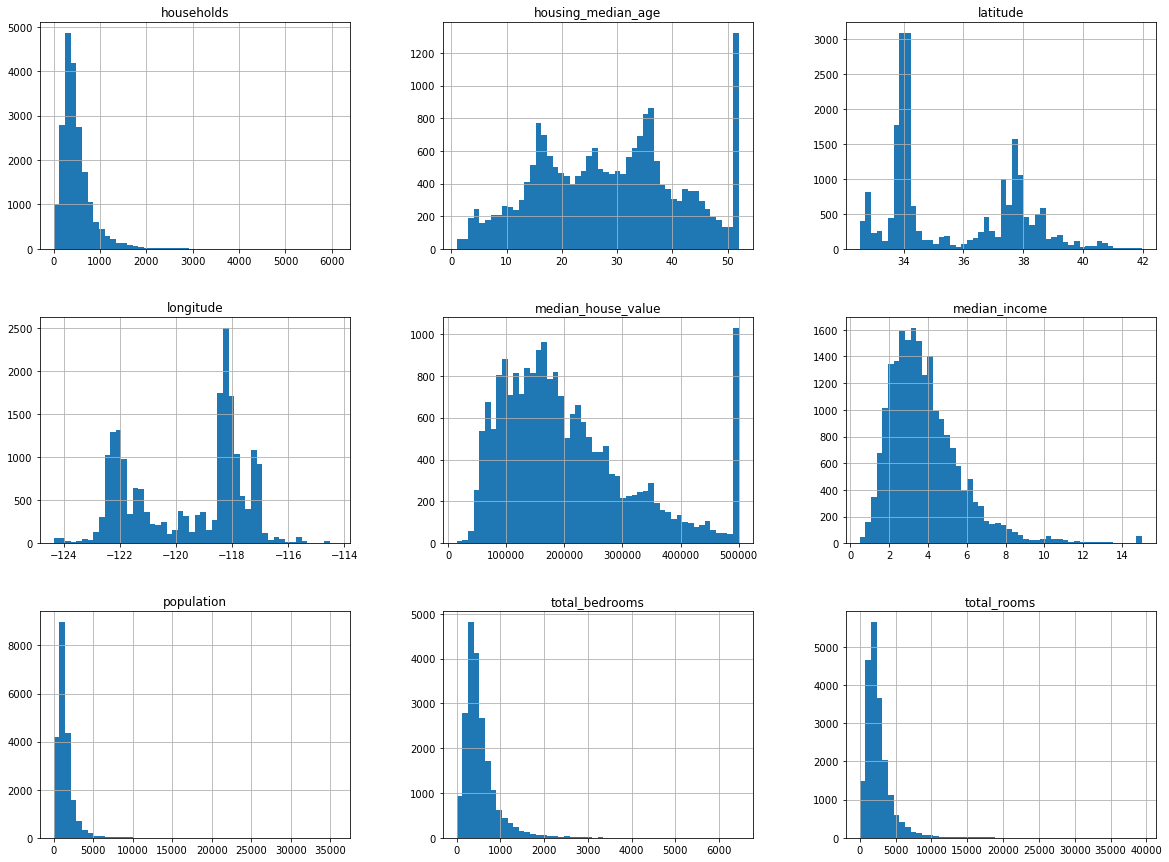

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))

## Create a test set

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(train_set.shape)
print(test_set.shape)

(16512, 10)
(4128, 10)


## Do stratified sampling
Assuming median_income is an important predictor, we need to categorize it. It is important to build categories such that there are a sufficient number of data points in each strata, else the stratum's importance is biased. To make sure, we need not too many strata (like it is now with median income) and strata are relatively wide.

In [14]:
# scale the median income down by dividing it by 1.5 and rounding up those which are greater than 5 to 5.0
import numpy as np
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5) #up round to integers

#replace those with values > 5 with 5.0, values < 5 remain as is
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

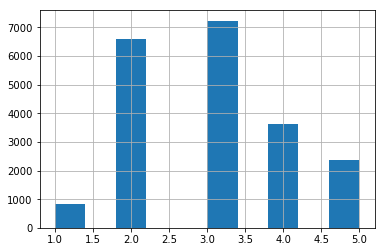

In [15]:
housing['income_cat'].hist()

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Now remove the `income_cat` field used for this sampling. We will learn on the `median_income` data instead

In [27]:
for _temp in (strat_test_set, strat_train_set):
    _temp.drop("income_cat", axis=1, inplace=True)

In [38]:
# Write the train and test data to disk
strat_test_set.to_csv('./housing_strat_test.csv')
strat_train_set.to_csv('./housing_strat_train.csv')

## Exploratory data analysis

C:\Anaconda3\envs\ml\lib\site-packages\pandas\plotting\_core.py:196: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn("'color' and 'colormap' cannot be used "


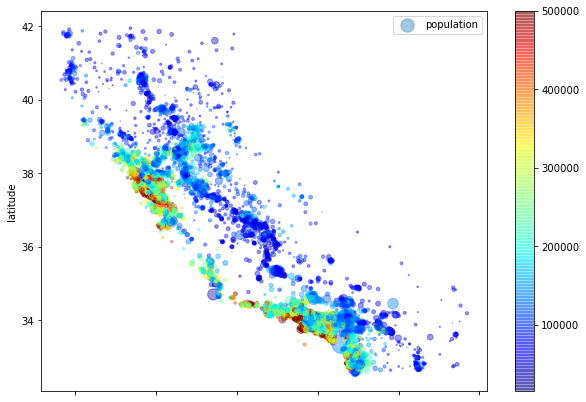

In [37]:
strat_train_set.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=strat_train_set['population']/100,
                    label='population', figsize=(10,7), color=strat_train_set['median_house_value'], 
                     cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

Do pairwise plot to understand how each feature is correlated to each other

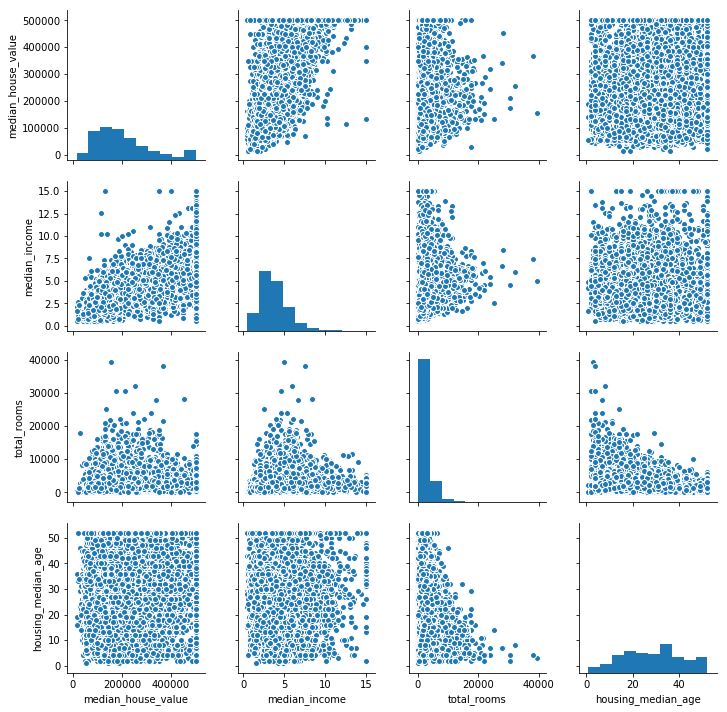

In [50]:
import seaborn as sns
sns.pairplot(data=strat_train_set[['median_house_value','median_income','total_rooms','housing_median_age']])

Focussing on relationship between income and house value

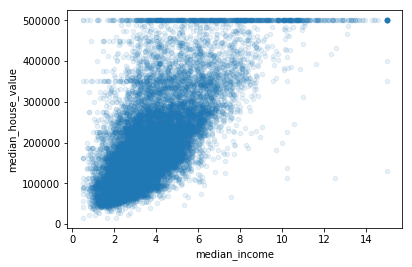

In [51]:
strat_train_set.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

#### Creating new features that are meaningful and also useful in prediction
Create the number of rooms per household, bedrooms per household, ratio of bedrooms to the rooms, number of people per household. We do this on the whole dataset, then collect the train and test datasets.

In [52]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_household'] = housing['total_bedrooms'] / housing['households']
housing['bedrooms_per_rooms'] = housing['total_bedrooms'] / housing['total_rooms']

In [54]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value        1.000000
median_income             0.688075
income_cat                0.643892
rooms_per_household       0.151948
total_rooms               0.134153
housing_median_age        0.105623
households                0.065843
total_bedrooms            0.049686
population               -0.024650
longitude                -0.045967
bedrooms_per_household   -0.046739
latitude                 -0.144160
bedrooms_per_rooms       -0.255880
Name: median_house_value, dtype: float64

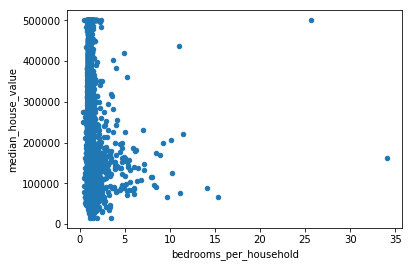

In [59]:
housing.plot(kind='scatter', x='bedrooms_per_household',y='median_house_value', alpha=0.5)

### Prepare data for ML

In [60]:
#create a copy without the house value column
housing = strat_train_set.drop('median_house_value', axis=1)
#create a copy of house value column into a new series, which will be the labeled data
housing_labels = strat_test_set['median_house_value'].copy()

#### Fill missing values using `Imputer` - using median values

In [61]:
from sklearn.preprocessing import Imputer
housing_imputer = Imputer(strategy='median')

In [62]:
#drop text columns let Imputer learn
housing_numeric = housing.drop('ocean_proximity', axis=1)
housing_imputer.fit(housing_numeric)
housing_imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [64]:
_x = housing_imputer.transform(housing_numeric)
housing_filled= pd.DataFrame(_x, columns=housing_numeric.columns)

In [66]:
housing_filled['ocean_proximity'] = housing['ocean_proximity']
housing_filled.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,NEAR BAY
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,NEAR BAY
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR BAY
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,NEAR BAY
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,NEAR BAY


#### Transform categorical features to numeric - OneHotEncoder
We can use `LabelEncoder` of scipy to enumerate the `ocean_proximity` category. However ML algorithm should not associate higher values as desireable or should not think values 1,2 are closer than values 1,4. So we transform the categories into new columns of booleans using `OneHotEncoder`.

We can do both enumeration then to booleans using `LabelBinarizer`